## 1. Multi-class Classification w/ Custom ResNet model
*     Dataset: CIFAR10



*    Reference. https://github.com/Justin-A/DeepLearning101/blob/master/4-4_CIFAR_ResNet.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
# 런타임 - 런타임 유형 변경 - T4 GPU
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.1.0+cu121  Device: cpu


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)


100%|██████████| 170498071/170498071 [00:03<00:00, 43398241.76it/s]


Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


In [5]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


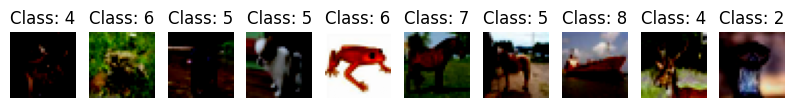

In [6]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [7]:
## Question 1.
## Building custom ResNet model

class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1):
      # Basic block 정의, in_planes : input channel size, planes : ouput channels size
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        # 첫번째 conv layer, 3x3 convolution with padding and no bias
        self.bn1 = nn.BatchNorm2d(planes)
        # batch normalization layer
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False)
        # 두번째 conv layer, 3x3 convolution with fixed stride=1, padding, and no bias
        self.bn2 = nn.BatchNorm2d(planes)
        # batch normalization layer

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
          # if stride가 1이 아닐 때, 또는 input channel size와 ouput channels size가 같지 않을 때,
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(planes))
            # 1x1 convolution with specific stride and no bias, and batch normalization 의 shortcut connection이 추가

    def forward(self, x):
      # Basic block의 forward pass
        out = F.relu(self.bn1(self.conv1(x)))
        # 첫번째 conv layer와 batch normalization 이후 activation functionc으로 ReLU를 적용
        out = self.bn2(self.conv2(out))
        # 전 단계의 output을 다시 input으로 하여 두번째 conv layer와 batch normalization을 적용
        out += self.shortcut(x)
        # shortcut connection을 적용
        out = F.relu(out)
        # 전 단계의 output에 ReLU를 적용
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes = 10):
      # number of output class : 10
        super(ResNet, self).__init__()
        self.in_planes = 16
        # input data channel size : 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1, bias = False)
        # 첫번째 conv layer
        # 3x3 convolution layer with 3 input channels, 16 output channels, stride=1, padding and no bias
        self.bn1 = nn.BatchNorm2d(16)
        # batch normalization layer
        self.layer1 = self._make_layer(16, 2, stride = 1)
        # 2개의 Basic block with 16 ouput channels and tride =1
        self.layer2 = self._make_layer(32, 2, stride = 2)
        # 2개의 Basic block with 32 ouput channels and tride =2
        self.layer3 = self._make_layer(64, 2, stride = 2)
        # 2개의 Basic block with 64 ouput channels and tride =2
        self.linear = nn.Linear(64, num_classes)
        # linear layer with 64 input features

    def _make_layer(self, planes, num_blocks, stride):
      # 여러개의 Basic block을 하나의 모듈로 묶어준다.
        strides = [stride] + [1] * (num_blocks  - 1)
        # stride value = specific stride + (number of blocks -1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
            # in_planes를 현재의 planes로 업데이트
        return nn.Sequential(*layers)

    def forward(self, x):
      # Resnet class의 forward pass
        out = F.relu(self.bn1(self.conv1(x)))
        # 첫번째 conv layer와 batch normalization 이후 activation functionc으로 ReLU를 적용
        out = self.layer1(out)
        # 첫번째 self.layer 적용
        out = self.layer2(out)
        # 두번째 self.layer 적용
        out = self.layer3(out)
        # 세번째 self.layer 적용
        out = F.avg_pool2d(out, 8)
        # average pooling with 8x8 kernel
        out = out.view(out.size(0), -1)
        # flatten the output data
        out = self.linear(out)
        # self.linear layer 적용
        return out

### Question 1. Explain the code above (building custom ResNet model) in detail -- line-by-line recommended

In [8]:
model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [9]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [10]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [11]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.425300
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.691081
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.367108
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.394684
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.179797
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.145958
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.432581
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 0.880686

[EPOCH: 1], 	Test Loss: 0.9635, 	Test Accuracy: 65.86 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.203521
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 0.854216
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 0.975175
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 0.894955
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.559999
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.004361
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 0.633751
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 0.859453

[EPOCH: 2], 	Test Loss: 0.7962, 	Test Accuracy: 71.89 % 